## Initialisation

In [1]:
import pandas as pd
import duckdb
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
import json
import pyarrow as pa
import pyarrow.parquet as pq
import ast
import warnings
from pathlib import Path
from sklearn.metrics import r2_score
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

/Users/ishanyash17/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Pre Processing

In [2]:
def load_data(file_path, sheet_name=None, return_all=False):
    """
    Load data from an .xlsx file.
    
    Parameters:
        file_path (Path): Path to the Excel file.
        sheet_name (str, optional): Name of the sheet to return.
            If provided, returns only that sheet.
        return_all (bool, optional): If True, returns a dictionary with all sheets.
            Default is False.
    
    Returns:
        DataFrame or dict: If return_all is False, returns a DataFrame (either the sheet specified
            by sheet_name or the first sheet if sheet_name is None).
            If return_all is True, returns a dict of {sheet_name: DataFrame}.
    """
    if file_path.suffix == '.xlsx':
        # Read all sheets into a dictionary
        sheets_dict = pd.read_excel(str(file_path), sheet_name=None)
        
        if return_all:
            return sheets_dict
        
        if sheet_name is not None:
            if sheet_name in sheets_dict:
                return sheets_dict[sheet_name]
            else:
                raise ValueError(f"Sheet '{sheet_name}' not found in the workbook.")
        
        # No specific sheet provided, so return the first sheet
        first_sheet = list(sheets_dict.values())[0]
        return first_sheet
    else:
        return None

In [3]:
file_path = Path.cwd().parent / "notebooks" / "data_nb" / "raw" / "data_cs.xlsx"

In [4]:
df_seap1 = load_data(file_path, sheet_name='SEA P1')
df_seap1.head()

,Portfolio 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Daily Budget,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,Cost,Clicks,Listing Views,Applications,Listing Save Clicks,Clicks on Map
3,352.404836,15647.619006,22862.4,1234.492,6858.72,1357.9412
4,406.561591,17043.209898,24734.6,1336.642,7420.38,1470.3062


In [5]:
df_seap1 = df_seap1.drop(index=[0, 1])
df_seap1.columns = df_seap1.iloc[0]  # Use the first row as column names
df_seap1 = df_seap1.iloc[1:].reset_index(drop=True)  # Drop the first row and reset index
df_seap1.head()

2,Cost,Clicks,Listing Views,Applications,Listing Save Clicks,Clicks on Map
0,352.404836,15647.619006,22862.4,1234.492,6858.72,1357.9412
1,406.561591,17043.209898,24734.6,1336.642,7420.38,1470.3062
2,466.148071,18214.412478,26389.2,1440.242,7916.76,1584.2662
3,533.344237,19274.453048,27998.8,1542.844,8399.64,1697.1284
4,565.553931,19778.707224,28747.2,1590.364,8624.16,1749.4004


In [6]:
df_seap2 = load_data(file_path, sheet_name='SEA P2')
df_progd = load_data(file_path, sheet_name='Programmatic Display')
df_partner = load_data(file_path, sheet_name='Partner')

In [7]:
df_seap2 = df_seap2.drop(index=[0, 1])
df_seap2.columns = df_seap2.iloc[0]  # Use the first row as column names
df_seap2 = df_seap2.iloc[1:].reset_index(drop=True)  # Drop the first row and reset index
df_seap2.head()

2,Cost,Clicks,Listing Views,Applications,Listing Save Clicks,Clicks on Map
0,381.530984,12013.400982,9146.66,587.318,2743.998,646.0498
1,454.850694,13679.231938,10359.92,655.238,3107.976,720.7618
2,503.414575,14649.551336,11077.74,697.944,3323.322,767.7384
3,519.166133,14890.810198,11265.32,711.074,3379.596,782.1814
4,534.917692,15132.069058,11452.88,724.202,3435.864,796.6222


In [8]:
df_progd.columns = df_progd.iloc[0]
df_progd = df_progd.iloc[1:].reset_index(drop=True)
df_progd.head()

,Campaign Name,Impr.,Clicks,Listing Views,Listing Save Clicks,Applications,Clicks on Map,Costs,Clicks Elasticity,Listing Views Elasticity,Listing Save Clicks Elasticity,Applications Elasticity,Clicks on Map Elasticity
0,Mobile,42188290,552613,1781592,165783.9,44334,48767.4,26795.330712,0.75,0.61,0.59,0.62,0.57
1,Desktop,55246662,565154,2021806,169546.2,88286,97114.6,59235.921814,0.65,0.54,0.53,0.53,0.51


In [9]:
df_progd = df_progd.rename(columns={"Impr.": "Impressions"})
df_progd = df_progd.rename(columns={"Clicks ": "Clicks"})
df_progd.columns

Index(['Campaign Name', 'Impressions', 'Clicks', 'Listing Views',
       'Listing Save Clicks', 'Applications', 'Clicks on Map', 'Costs',
       'Clicks Elasticity', 'Listing Views Elasticity',
       'Listing Save Clicks Elasticity', 'Applications Elasticity',
       'Clicks on Map Elasticity'],
      dtype='object', name=0)

In [10]:
df_partner

,Scenario:
0,Partners have a fixed CpC of 0.10€
1,The minimal amount of clicks that partner webs...
2,The maximal amount of clicks that partner webs...
3,"In this range, StepStone can choose what amoun..."
4,The conversion rates are as follows:
5,*Listing Views per Click: 1.62
6,*Listing Save Clicks per Click: 0.28
7,*Applications per Click: 0.06
8,*Clicks on Map per Click: 0.07


In [11]:
# Convert all numeric columns to integers by rounding first
df_seap1 = df_seap1.round().astype(int)
df_seap2 = df_seap2.round().astype(int)

In [12]:
df_seap1.head()

2,Cost,Clicks,Listing Views,Applications,Listing Save Clicks,Clicks on Map
0,352,15647,22862,1234,6858,1357
1,406,17043,24734,1336,7420,1470
2,466,18214,26389,1440,7916,1584
3,533,19274,27998,1542,8399,1697
4,565,19778,28747,1590,8624,1749


In [13]:
df_seap1.shape

(260, 6)

In [14]:
# Define a function to plot all columns against Cost
def plot_columns_against_cost(df, title):
    plt.figure(figsize=(10, 6))
    x = df['Cost']
    for col in df.columns:
        if col != 'Cost':  # Exclude cost from being plotted against itself
            plt.plot(x, df[col], marker='o', linestyle='-', label=col)

    plt.xlabel("Cost (€)")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

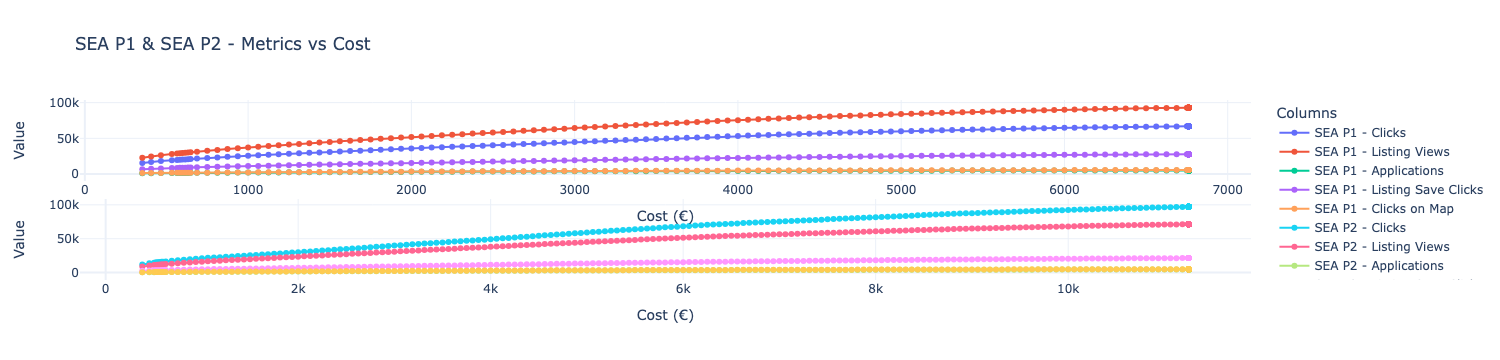

In [46]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_columns_against_cost_stacked(df1, df2):
    # Create a figure with 2 rows and 1 column
    fig = make_subplots(rows=2, cols=1, shared_xaxes=False, vertical_spacing=0.1)

    # --- First subplot (SEA P1) ---
    x1 = df1['Cost']
    for col in df1.columns:
        if col != 'Cost':
            fig.add_trace(
                go.Scatter(
                    x=x1,
                    y=df1[col],
                    mode='lines+markers',
                    name=f"SEA P1 - {col}"
                ),
                row=1, col=1
            )

    # --- Second subplot (SEA P2) ---
    x2 = df2['Cost']
    for col in df2.columns:
        if col != 'Cost':
            fig.add_trace(
                go.Scatter(
                    x=x2,
                    y=df2[col],
                    mode='lines+markers',
                    name=f"SEA P2 - {col}"
                ),
                row=2, col=1
            )

    # Update layout for aesthetics
    fig.update_layout(
        title="SEA P1 & SEA P2 - Metrics vs Cost",
        template="plotly_white",
        hovermode="x unified",
        legend_title="Columns"
    )

    # Customize axes for each row
    fig.update_xaxes(title_text="Cost (€)", row=1, col=1)
    fig.update_yaxes(title_text="Value", row=1, col=1)
    fig.update_xaxes(title_text="Cost (€)", row=2, col=1)
    fig.update_yaxes(title_text="Value", row=2, col=1)

    fig.show()

# Example usage:
plot_columns_against_cost_stacked(df_seap1, df_seap2)


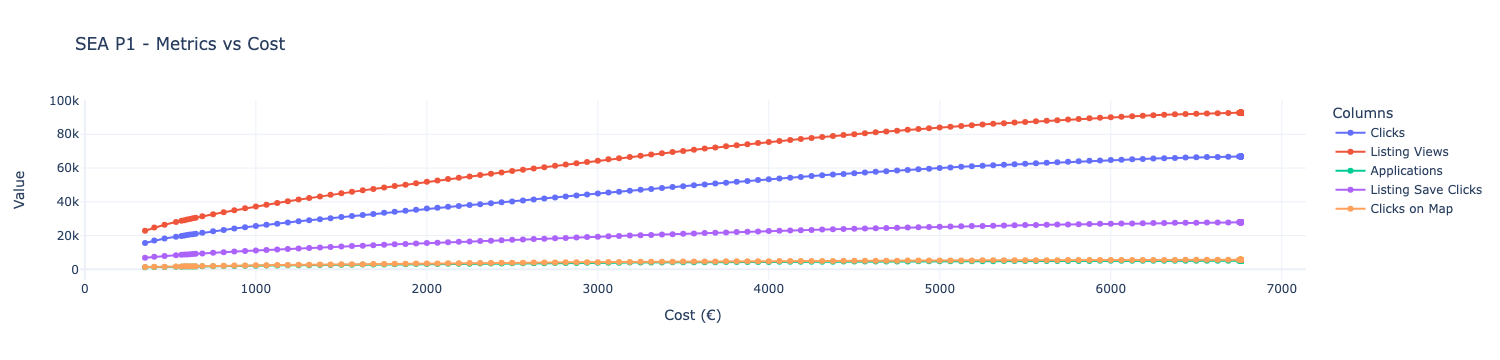

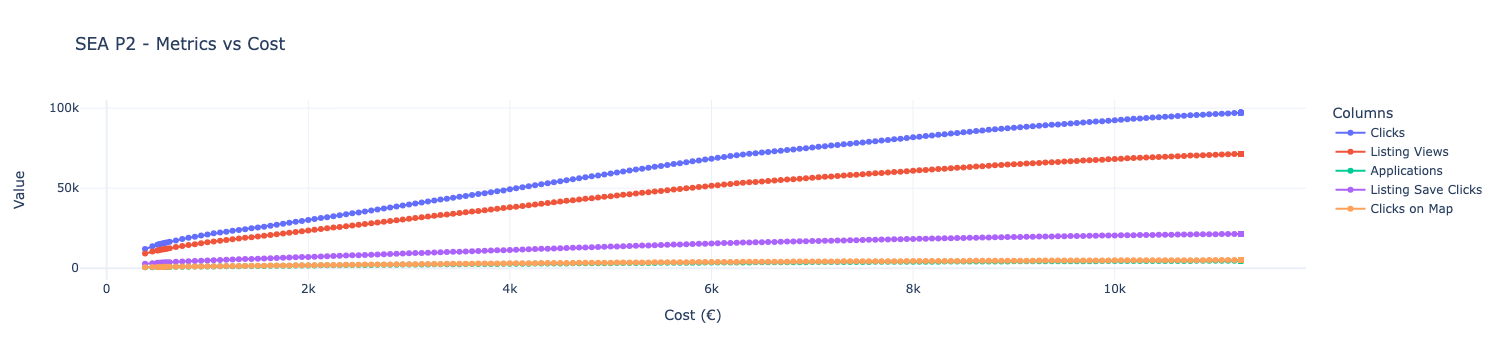

In [45]:
plot_columns_against_cost(df_seap1, "SEA P1 - Metrics vs Cost")
plot_columns_against_cost(df_seap2, "SEA P2 - Metrics vs Cost")

Assumption: 
- If users are exploring multiple options or revisiting the page then the Listing views can be higher than the clicks as seen in the SEA P1 channel here.
- Number of application and clicks on map are nearly the same, suggesting heavy correlation on what a successful application needs to have as a feature (i.e. Geo data) 

Observation: 
- Number of clicks (and other features) are correlated to the increase in daily budget. 
- The cost for both the portfolios ranges from a certain limit and all the 260 data points are not necessarily unique, suggesting the daily budget allocation reaches saturation at certain value of the cost. 

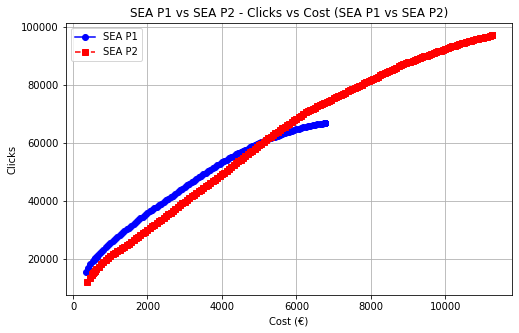

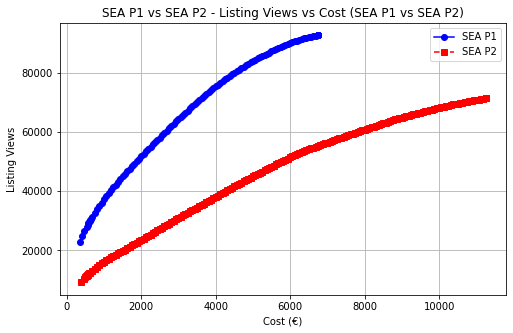

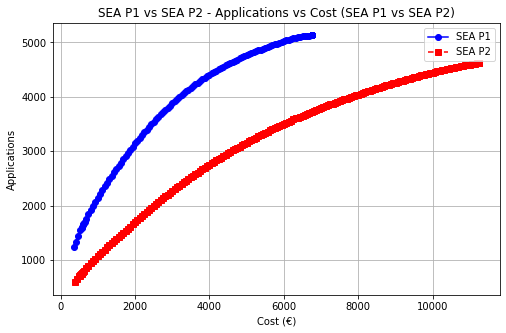

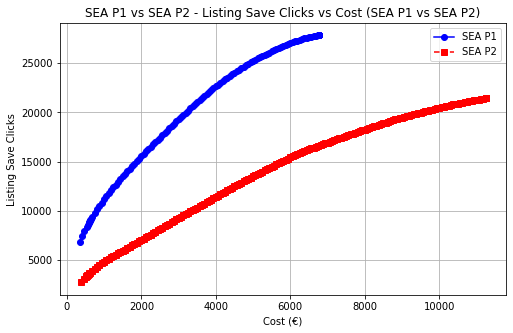

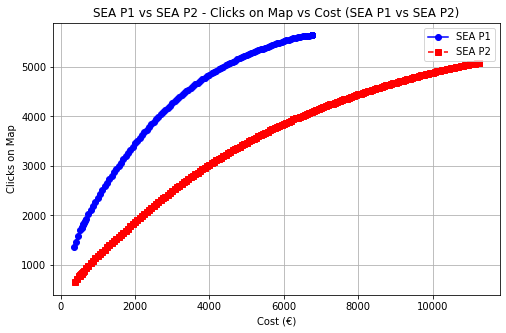

In [17]:
# Function to compare SEA P1 vs SEA P2 for each metric against Cost
def compare_sea_p1_p2(df1, df2, title_prefix):
    for col in df1.columns:
        if col != 'Cost':  # Exclude Cost from being plotted against itself
            plt.figure(figsize=(8, 5))
            plt.plot(df1['Cost'], df1[col], marker='o', linestyle='-', color='b', label='SEA P1')
            plt.plot(df2['Cost'], df2[col], marker='s', linestyle='--', color='r', label='SEA P2')
            plt.xlabel("Cost (€)")
            plt.ylabel(col)
            plt.title(f"{title_prefix} - {col} vs Cost (SEA P1 vs SEA P2)")
            plt.legend()
            plt.grid(True)
            plt.show()

# Compare SEA P1 vs SEA P2 for each metric
compare_sea_p1_p2(df_seap1, df_seap2, "SEA P1 vs SEA P2")

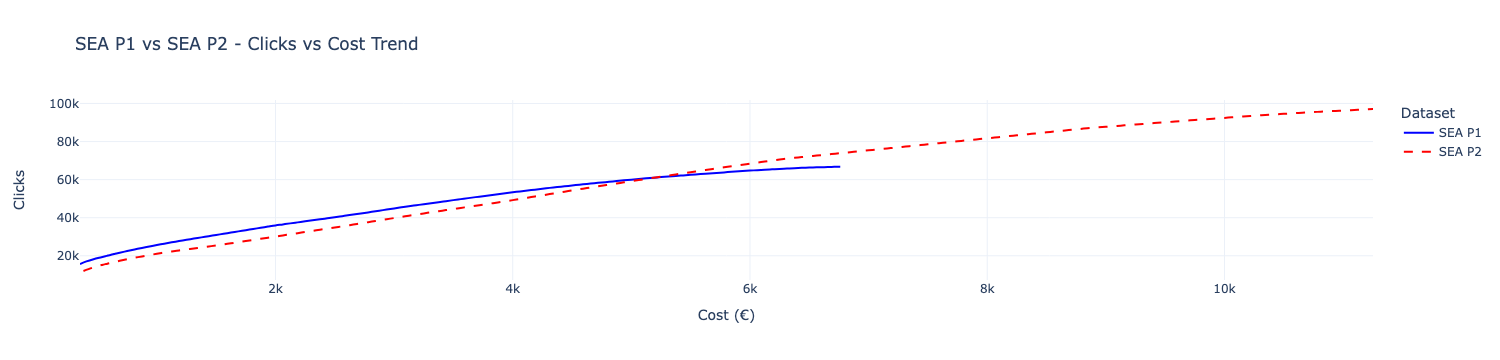

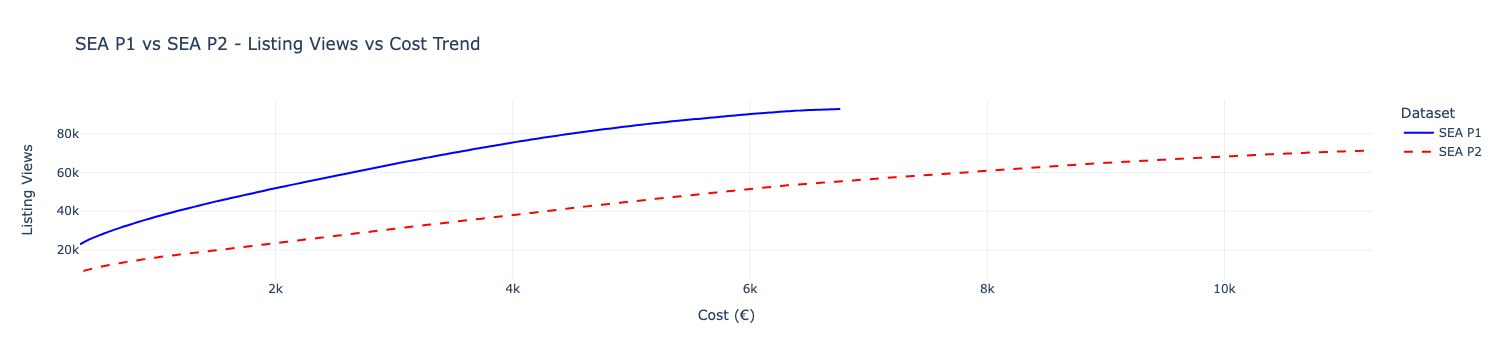

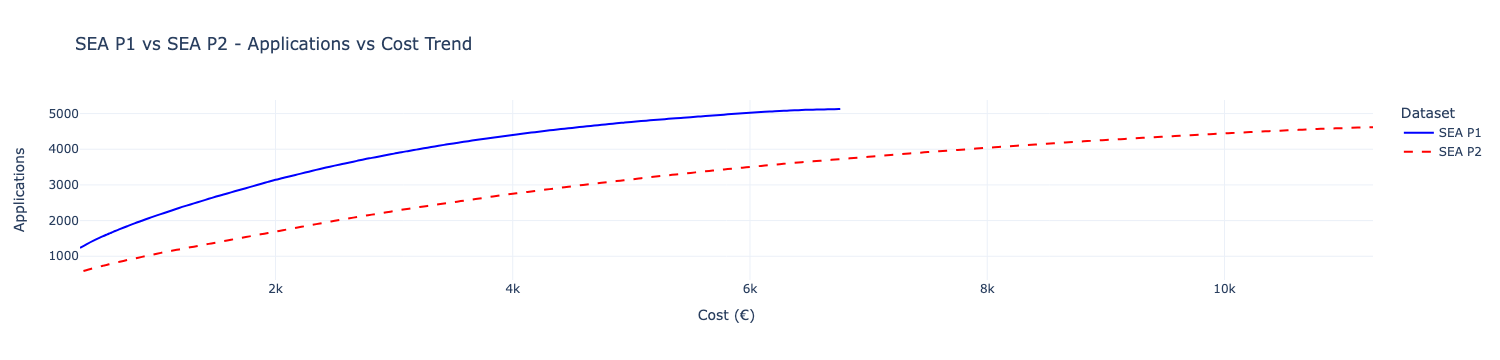

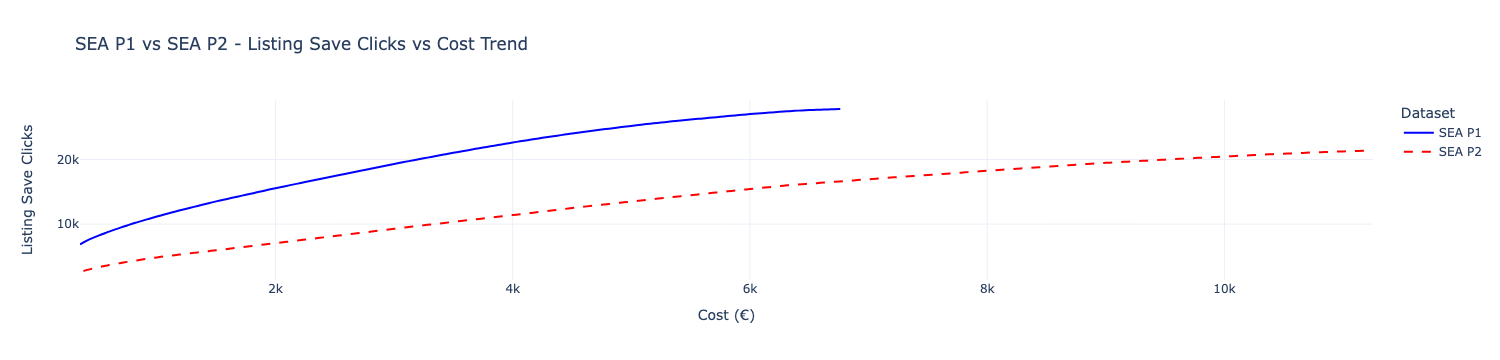

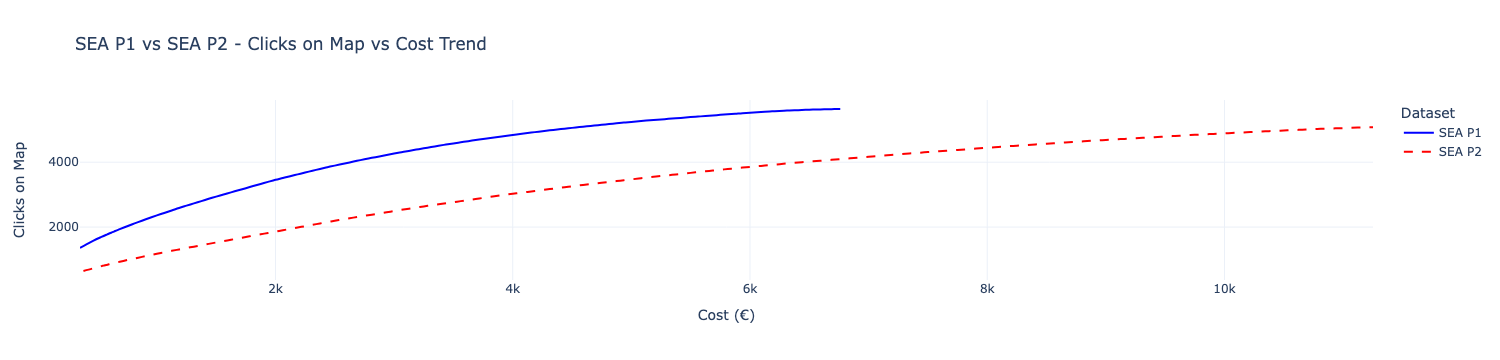

In [18]:
def compare_sea_p1_p2_trend(df1, df2, title_prefix):
    for col in df1.columns:
        if col != 'Cost':  # Exclude Cost from being plotted against itself
            fig = go.Figure()
            # Plot SEA P1 as a smooth trend line
            fig.add_trace(go.Scatter(
                x=df1['Cost'],
                y=df1[col],
                mode='lines',  # Use only lines for a clean trend line look
                name='SEA P1',
                line=dict(color='blue', shape='spline', width=2)
            ))
            # Plot SEA P2 as a smooth trend line
            fig.add_trace(go.Scatter(
                x=df2['Cost'],
                y=df2[col],
                mode='lines',  # Use only lines for a clean trend line look
                name='SEA P2',
                line=dict(color='red', dash='dash', shape='spline', width=2)
            ))
            
            # Update layout for an aesthetic, interactive presentation
            fig.update_layout(
                title=f"{title_prefix} - {col} vs Cost Trend",
                xaxis_title="Cost (€)",
                yaxis_title=col,
                template="plotly_white",
                legend_title="Dataset",
                hovermode="x unified"
            )
            fig.show()

# Example usage:
compare_sea_p1_p2_trend(df_seap1, df_seap2, "SEA P1 vs SEA P2")


Observation: Looks like a quadratic function; has saturation point 

## Task 1

### **Maximizing Candidates per Listing – StepStone Marketing Allocation Strategy**

#### **1. What Does “Candidates per Listing” Mean in Practice?**
If you have **N total job listings** on StepStone, and across all your marketing channels you generate **X total applications**, then the **average number of candidates per listing** is:

\[
\text{Candidates per listing} = \frac{\text{Total Applications}}{\text{Number of Listings}}
\]

Assuming, **N is a fixed number of listings** on your platform (e.g., **10,000 active job listings**). If each listing is promoted across all the channels (**SEA, Programmatic, Partner**), then **N remains constant** even if you shift budget between channels.

Thus, **maximizing "candidates per listing" is the same as maximizing total applications** because **N is constant**.

---

#### **2. Two Common Approaches**

##### **2A. If All Channels Promote the Same Set of Listings**
- **Number of Listings (N)**: Constant across channels (e.g., **10,000 listings**).
- **Total Applications (X)**: Sum of all applications from **SEA P1 + SEA P2 + Programmatic + Partner**.

\[
\text{Avg. Candidates per listing} = \frac{\text{Apps from P1 + P2 + Programmatic + Partner}}{N}
\]

Since **N is fixed**, **maximizing total applications automatically maximizes candidates per listing**.

##### **2B. If Different Listings Are Allocated to Different Channels**
Sometimes listings are **distributed among channels**:
- **2,000 listings → SEA P1**
- **3,000 listings → SEA P2**
- **4,000 listings → Programmatic**, etc.

In this case, the overall **candidates per listing** formula is:

\[
\text{Candidates per listing (overall)} =
\left( \frac{\text{Apps from P1}}{N_{P1}} \times \frac{N_{P1}}{N_{\text{total}}} \right)
+ \left( \frac{\text{Apps from P2}}{N_{P2}} \times \frac{N_{P2}}{N_{\text{total}}} \right) + \dots
\]

Assuming that the **same listings across all channels are promoted**. And if that’s the case, we follow the **approach 2A**.

---

#### **3. What Exactly to Calculate for Each Channel?**
Given the data, you **know how many applications each channel generates** at different spending levels, but you **do not directly know the number of listings each channel supports**.

- **StepStone promotes listings dynamically across all channels**.
- **The simplest approach** is to assume a **single, common pool of listings (N total)**.
- **Summing all applications across all channels and dividing by N** gives:

\[
\text{Candidates per listing} = \frac{\sum \text{(Applications from each channel)}}{N}
\]

Since **N is constant**, the goal is to **maximize total applications**.

---

#### **4. Summary: Putting It Into Practice**
##### **Step 1: Build a “Cost → Applications” Function for Each Channel**
- **SEA P1/P2**: Tables mapping **daily cost** → **daily applications**.  
  - Multiply by **365** for **annual applications**.
- **Programmatic Display**: Monthly data → **scale to annual applications**.
- **Partner Channel**: CPC model with **min–max click range** → **convert clicks to total applications**.

##### **Step 2: Decide on Budget Allocation**  
For example, **assume a total budget of 10M €**:
- **Try different budget distributions** across P1, P2, Programmatic, and Partner.
- **For each budget scenario**, compute **total applications across all channels**.

##### **Step 3: Pick the Best Allocation**
- The **scenario with the highest total applications is optimal** because it **maximizes candidates per listing**.
- Example allocation scenarios:
  - **Scenario 1**: 3M € to SEA P1, 2M € to SEA P2, 3M € to Programmatic, 2M € to Partner.
  - **Scenario 2**: 4M € to SEA P1, 1M € to SEA P2, 3M € to Programmatic, 2M € to Partner.
  - Compute total applications for each scenario and **select the best one**.

By **maximizing total applications**, we automatically **maximize candidates per listing**.

In [19]:
# cleaning
df_progd['Costs'] = pd.to_numeric(df_progd['Costs'], errors='coerce')
df_progd['Applications'] = pd.to_numeric(df_progd['Applications'], errors='coerce')

# Check for any missing values created by coercion:
print(df_progd[['Costs', 'Applications']].isnull().sum())

0
Costs           0
Applications    0
dtype: int64


### Important functions for budget allocation: 

In [20]:
def estimate_sea_applications(df_sea, annual_budget):
    """
    Given a SEA DataFrame (daily data) and an allocated annual budget,
    estimate the total annual applications.
    
    - df_sea: DataFrame with at least two columns: 'Cost' and 'Applications' (daily figures)
    - annual_budget: allocated budget (in €) for the channel for the year.
    
    Returns the estimated annual applications.
    """
    # Calculate the equivalent daily spend:
    daily_budget = annual_budget / 365.0
    # Use linear interpolation on the provided table:
    daily_apps = np.interp(daily_budget, df_sea['Cost'], df_sea['Applications'])
    # Return annual applications:
    return daily_apps * 365.0

In [21]:
def estimate_prog_applications(df_progd, annual_budget):
    """
    Given a Programmatic Display DataFrame (monthly data) and an allocated annual budget,
    estimate the total annual applications.
    
    - df_progd: DataFrame with at least two columns: 'Costs' and 'Applications' (monthly figures)
    - annual_budget: allocated annual budget (in €) for the programmatic channel.
    
    Returns the estimated annual applications.
    """
    # Calculate the equivalent monthly spend:
    monthly_budget = annual_budget / 12.0
    # Use linear interpolation on the monthly table:
    monthly_apps = np.interp(monthly_budget, df_progd['Costs'], df_progd['Applications'])
    # Return annual applications:
    return monthly_apps * 12.0

In [22]:
def estimate_partner_applications(annual_budget, cpc=0.10, app_rate=0.06):
    """
    Given an allocated annual budget for the Partner channel,
    estimate the total annual applications.
    
    - annual_budget: allocated annual budget (in €) for Partner.
    - cpc: cost per click (default 0.10 €)
    - app_rate: applications per click (default 0.06)
    
    Returns the estimated annual applications.
    """
    # Total clicks purchased = budget / cpc, then applications = clicks * app_rate.
    return (annual_budget / cpc) * app_rate

In [23]:
def compute_overall_metrics(budget_alloc, df_seap1, df_seap2, df_progd, total_listings):
    """
    Given a budget allocation dictionary (keys: 'SEA P1', 'SEA P2', 'Programmatic', 'Partner'),
    and the respective data frames (df_seap1, df_seap2 for daily data, df_progd for monthly data),
    and the total number of listings,
    compute:
      - The estimated annual applications from each channel,
      - The overall total annual applications,
      - And the candidates per listing.
    
    budget_alloc should be a dict with keys: 
      'SEA P1', 'SEA P2', 'Programmatic', 'Partner' (values in €).
    """
    # Estimate applications for each channel:
    apps_p1 = estimate_sea_applications(df_seap1, budget_alloc.get('SEA P1', 0))
    apps_p2 = estimate_sea_applications(df_seap2, budget_alloc.get('SEA P2', 0))
    apps_prog = estimate_prog_applications(df_progd, budget_alloc.get('Programmatic', 0))
    apps_partner = estimate_partner_applications(budget_alloc.get('Partner', 0))
    
    # Total applications from all channels:
    total_apps = apps_p1 + apps_p2 + apps_prog + apps_partner
    # Candidates per listing is total apps divided by the number of listings:
    candidates_per_listing = total_apps / total_listings if total_listings > 0 else np.nan
    
    # Return a dictionary of results:
    return {
        'Total Applications': total_apps,
        'Candidates per Listing': candidates_per_listing,
        'Breakdown': {
            'SEA P1': apps_p1,
            'SEA P2': apps_p2,
            'Programmatic': apps_prog,
            'Partner': apps_partner
        }
    }

Starting point

In [24]:
# Define a sample budget allocation (in €)
budget_alloc = {
    'SEA P1': 3_000_000,        # 3M € allocated to SEA P1
    'SEA P2': 2_000_000,        # 2M € allocated to SEA P2
    'Programmatic': 3_000_000,  # 3M € allocated to Programmatic Display
    'Partner': 2_000_000        # 2M € allocated to Partner
}

total_listings = 10_000  # Example: 10,000 job listings

# Compute overall metrics
results = compute_overall_metrics(budget_alloc, df_seap1, df_seap2, df_progd, total_listings)

In [25]:
results

{'Total Applications': 5346625.225806451,
 'Candidates per Listing': 534.6625225806451,
 'Breakdown': {'SEA P1': 1871720.0,
  'SEA P2': 1215473.2258064516,
  'Programmatic': 1059432.0,
  'Partner': 1200000.0}}

Now Getting the best possible allocation to maximise the "Candidates per Listing"

In [26]:
# Define the objective function that takes an allocation vector and returns negative total applications.
def objective(x, df_seap1, df_seap2, df_progd, total_listings):
    # x[0] = SEA P1, x[1] = SEA P2, x[2] = Programmatic, x[3] = Partner
    budget_alloc = {
        'SEA P1': x[0],
        'SEA P2': x[1],
        'Programmatic': x[2],
        'Partner': x[3]
    }
    # Use the function we defined earlier to compute overall metrics:
    results = compute_overall_metrics(budget_alloc, df_seap1, df_seap2, df_progd, total_listings)
    # We want to maximize total applications; optimization routines minimize, so return the negative.
    return -results['Total Applications']

# Constraint: The sum of the budgets must equal 10M €.
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 10_000_000}]

# Bounds: each channel gets between 0 and 10M € (you can adjust if needed).
bounds = [(0, 10_000_000)] * 4

# Initial guess: an even split.
x0 = np.array([2.5e6, 2.5e6, 2.5e6, 2.5e6])

In [27]:
# Run the optimizer.
result = minimize(objective, x0, args=(df_seap1, df_seap2, df_progd, total_listings),
                  bounds=bounds, constraints=cons)

print("Optimal Allocation (in €):")
print("SEA P1: ", result.x[0])
print("SEA P2: ", result.x[1])
print("Programmatic: ", result.x[2])
print("Partner: ", result.x[3])

Optimal Allocation (in €):
SEA P1:  1266633.5944193937
SEA P2:  1100157.8320554134
Programmatic:  615547.9692869151
Partner:  7017660.604238278


### Assumption: For SEA channels, we assume the daily data can be interpolated linearly to any daily budget within the given range.

In [28]:
# To see the achieved total applications and candidates per listing:
optimal_budget = {
    'SEA P1': result.x[0],
    'SEA P2': result.x[1],
    'Programmatic': result.x[2],
    'Partner': result.x[3]
}

optimal_results = compute_overall_metrics(optimal_budget, df_seap1, df_seap2, df_progd, total_listings)
optimal_results

{'Total Applications': 7485292.86902924,
 'Candidates per Listing': 748.529286902924,
 'Breakdown': {'SEA P1': 1514074.9197003322,
  'SEA P2': 830283.4885465171,
  'Programmatic': 930338.0982394244,
  'Partner': 4210596.362542966}}

### Checking the Quadratic approach as the data (above) looked like a quadratic function

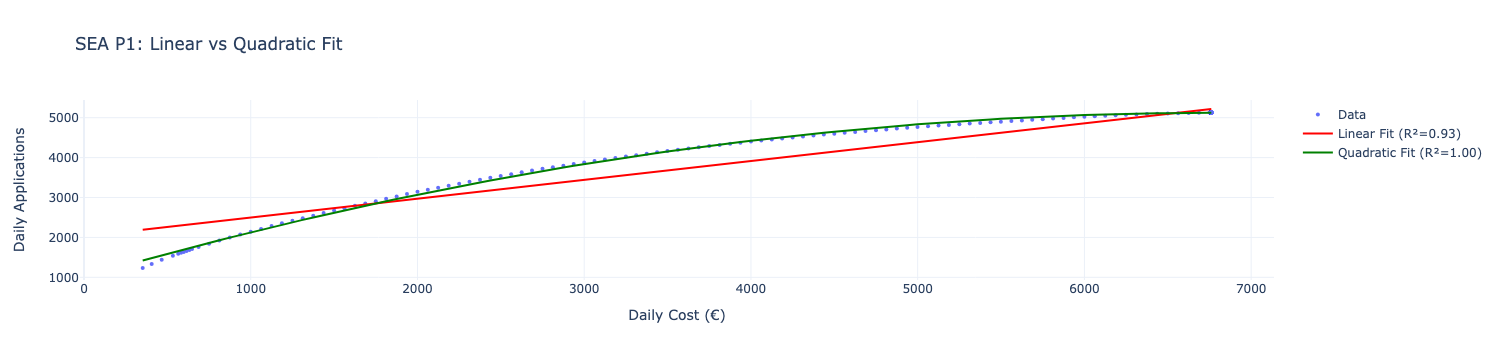

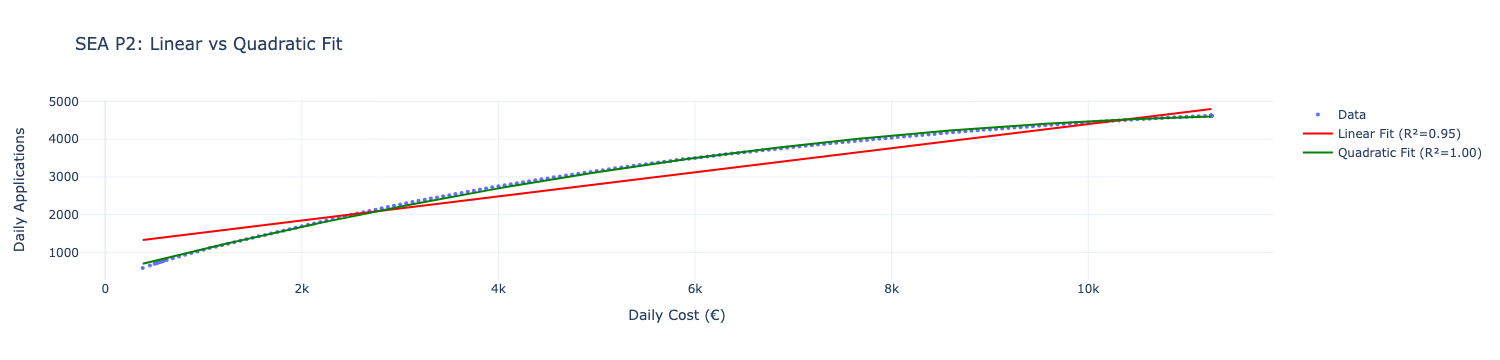

In [29]:
def plot_fit_models(df, title):
    # Ensure 'Cost' and 'Applications' are numeric arrays
    x = df['Cost'].values.astype(float)
    y = df['Applications'].values.astype(float)

    # Fit a linear model (degree 1)
    linear_coeff = np.polyfit(x, y, 1)
    linear_fit = np.poly1d(linear_coeff)
    y_linear_pred = linear_fit(x)
    r2_linear = r2_score(y, y_linear_pred)

    # Fit a quadratic model (degree 2)
    poly2_coeff = np.polyfit(x, y, 2)
    poly2_fit = np.poly1d(poly2_coeff)
    y_poly2_pred = poly2_fit(x)
    r2_poly2 = r2_score(y, y_poly2_pred)

    # Create interactive Plotly figure
    fig = go.Figure()
    
    # Scatter plot for original data
    fig.add_trace(go.Scatter(
        x=x, 
        y=y,
        mode='markers',
        name='Data',
        marker=dict(color='light blue', size=4)
    ))
    
    # Linear fit line
    fig.add_trace(go.Scatter(
        x=x, 
        y=y_linear_pred,
        mode='lines',
        name=f'Linear Fit (R²={r2_linear:.2f})',
        line=dict(color='red', width=2)
    ))
    
    # Quadratic fit line
    fig.add_trace(go.Scatter(
        x=x, 
        y=y_poly2_pred,
        mode='lines',
        name=f'Quadratic Fit (R²={r2_poly2:.2f})',
        line=dict(color='green', width=2)
    ))
    
    # Update layout for aesthetics
    fig.update_layout(
        title=title,
        xaxis_title='Daily Cost (€)',
        yaxis_title='Daily Applications',
        template='plotly_white',
        hovermode='x unified'
    )
    
    fig.show()

# Example usage:
# For SEA P1 data
plot_fit_models(df_seap1, "SEA P1: Linear vs Quadratic Fit")
# For SEA P2 data
plot_fit_models(df_seap2, "SEA P2: Linear vs Quadratic Fit")

In [30]:
df_progd = df_progd.rename(columns={"Cost": "Costs"})

Perfect fit for R^2 = 1.00, i.e. the data can be accurately forcasted when using quadratic function.

### Quad Approach

In [31]:
# For SEA P1:
x_p1 = df_seap1['Cost'].values  # daily cost
y_p1 = df_seap1['Applications'].values  # daily applications
coeff_p1 = np.polyfit(x_p1, y_p1, 2)  # fit a 2nd-degree polynomial
poly_p1 = np.poly1d(coeff_p1)        # create a polynomial function

# For SEA P2:
x_p2 = df_seap2['Cost'].values
y_p2 = df_seap2['Applications'].values
coeff_p2 = np.polyfit(x_p2, y_p2, 2)
poly_p2 = np.poly1d(coeff_p2)

In [32]:
def estimate_sea_applications_poly(poly_func, annual_budget):
    """
    Given a polynomial function (poly1d) that maps daily cost -> daily applications,
    and an allocated annual budget for the channel,
    return the total annual applications.
    """
    # Convert annual budget to daily budget:
    daily_budget = annual_budget / 365.0
    # Use the polynomial to predict daily applications:
    daily_apps = poly_func(daily_budget)
    # Multiply by 365 to get annual:
    return daily_apps * 365.0

In [33]:
def compute_overall_metrics_poly(budget_alloc, poly_p1, poly_p2, df_prog, total_listings):
    """
    budget_alloc: dict with keys 'SEA P1', 'SEA P2', 'Programmatic', 'Partner'
    poly_p1, poly_p2: the polynomial functions (poly1d) for P1, P2
    df_prog: your Programmatic data or polynomial approach
    total_listings: number of job listings
    """
    # Estimate SEA P1
    apps_p1 = estimate_sea_applications_poly(poly_p1, budget_alloc.get('SEA P1', 0))
    # Estimate SEA P2
    apps_p2 = estimate_sea_applications_poly(poly_p2, budget_alloc.get('SEA P2', 0))
    # Estimate Programmatic
    apps_prog = estimate_prog_applications(df_prog, budget_alloc.get('Programmatic', 0))
    # Estimate Partner
    apps_partner = estimate_partner_applications(budget_alloc.get('Partner', 0))
    
    # Total apps
    total_apps = apps_p1 + apps_p2 + apps_prog + apps_partner
    # Candidates per listing
    cpl = total_apps / total_listings if total_listings > 0 else 0
    
    return {
        'Total Applications': total_apps,
        'Candidates per Listing': cpl,
        'Breakdown': {
            'SEA P1': apps_p1,
            'SEA P2': apps_p2,
            'Programmatic': apps_prog,
            'Partner': apps_partner
        }
    }

In [34]:
def objective_quad(x, poly_p1, poly_p2, df_prog, total_listings):
    """
    x[0] = SEA P1, x[1] = SEA P2, x[2] = Programmatic, x[3] = Partner
    We'll return negative total applications for the optimizer to minimize.
    """
    budget_alloc = {
        'SEA P1': x[0],
        'SEA P2': x[1],
        'Programmatic': x[2],
        'Partner': x[3]
    }
    results = compute_overall_metrics_poly(budget_alloc, poly_p1, poly_p2, df_prog, total_listings)
    return -results['Total Applications']

In [35]:
# Constraints: sum of budgets = 10M
cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 10_000_000}]

# Bounds: each channel gets between 0 and 10M
bounds = [(0, 10_000_000)] * 4

# Initial guess: an even split
x0 = np.array([2.5e6, 2.5e6, 2.5e6, 2.5e6])

result_quad = minimize(
    objective_quad, 
    x0,
    args=(poly_p1, poly_p2, df_progd, total_listings),  # pass in your polynomial funcs and data
    bounds=bounds,
    constraints=cons
)

In [36]:
print("Optimal Allocation (in €) with Quadratic SEA Fit:")
print("SEA P1: ", result_quad.x[0])
print("SEA P2: ", result_quad.x[1])
print("Programmatic: ", result_quad.x[2])
print("Partner: ", result_quad.x[3])

Optimal Allocation (in €) with Quadratic SEA Fit:
SEA P1:  1372297.5235176203
SEA P2:  1151878.349559708
Programmatic:  979105.3648306903
Partner:  6496718.762091982


### Assumption: For SEA channels, we assume the daily data can be interpolated quadratically to any daily budget within the given range.

In [37]:
optimal_budget_quad = {
    'SEA P1': result_quad.x[0],
    'SEA P2': result_quad.x[1],
    'Programmatic': result_quad.x[2],
    'Partner': result_quad.x[3]
}
res_quad = compute_overall_metrics_poly(optimal_budget_quad, poly_p1, poly_p2, df_progd, total_listings)
print("\nTotal Applications:", res_quad['Total Applications'])
print("Candidates per Listing:", res_quad['Candidates per Listing'])
res_quad['Breakdown']


Total Applications: 7363231.18703447
Candidates per Listing: 736.323118703447


{'SEA P1': 1568923.2105020648,
 'SEA P2': 836844.7192772166,
 'Programmatic': 1059432.0,
 'Partner': 3898031.2572551887}

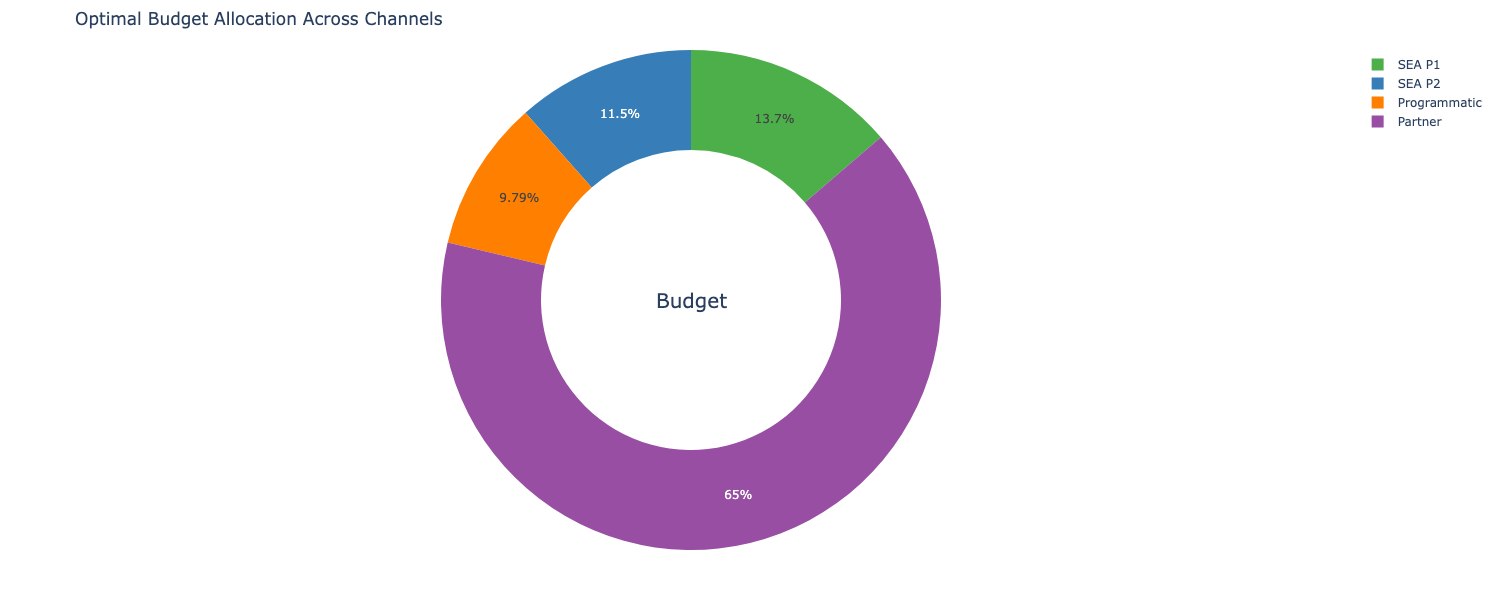

In [39]:
# Assume optimal_alloc is the result from your optimizer and channels are defined
optimal_alloc = result_quad.x  # result from your optimization routine
channels = ['SEA P1', 'SEA P2', 'Programmatic', 'Partner']

fig = go.Figure(
    data=[go.Pie(
        labels=channels,
        values=optimal_alloc,
        hole=0.6,
        marker=dict(colors=['#4daf4a','#377eb8','#ff7f00','#984ea3']),
        sort=False,
        # Make the pie occupy the full space (optional)
        domain=dict(x=[0,1], y=[0,1])
    )]
)

# Update the layout to control the overall figure size
fig.update_layout(
    width=800,   # Increase width
    height=600,  # Increase height
    margin=dict(l=50, r=50, t=50, b=50),  # Adjust margins as needed
    title_text="Optimal Budget Allocation Across Channels"
)

# Optionally add an annotation in the center
fig.add_annotation(dict(
    text="Budget",
    x=0.5, y=0.5,
    font_size=20,
    showarrow=False
))

fig.show()


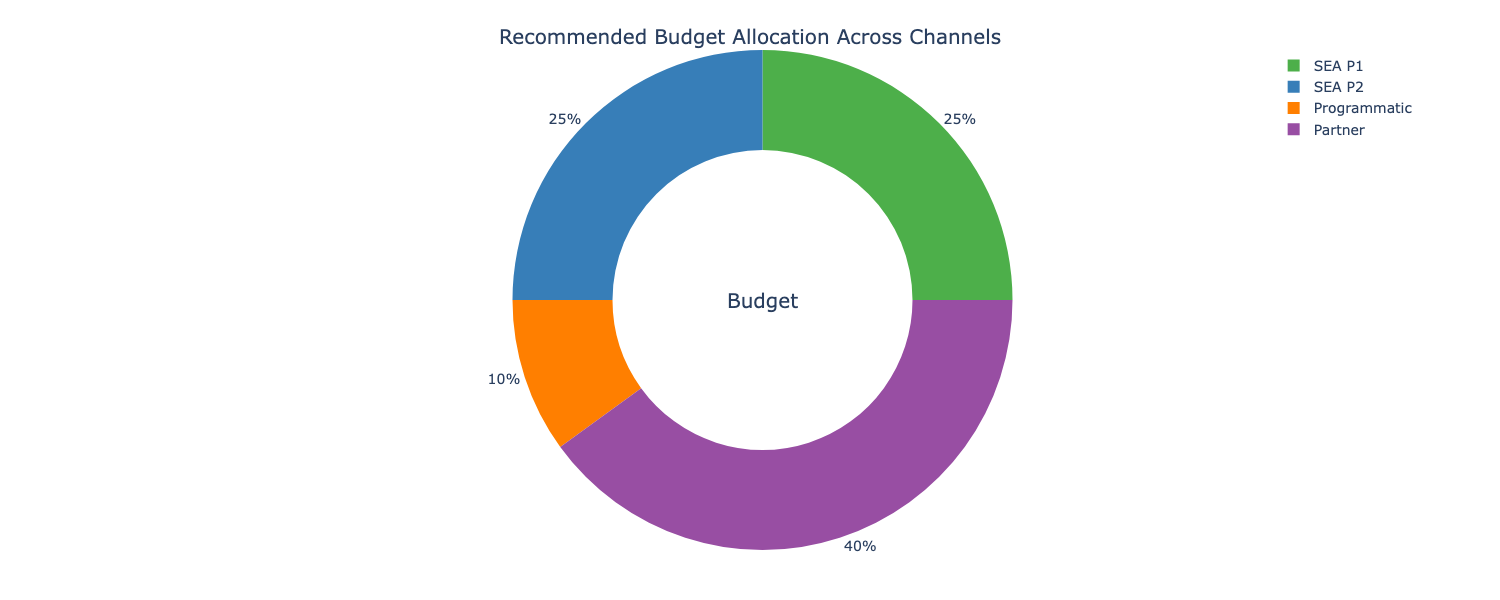

SEA P1: 25% (2.5M €)
SEA P2: 25% (2.5M €)
Programmatic: 10% (1.0M €)
Partner: 40% (4.0M €)


In [42]:
# Define the data
channels = ['SEA P1', 'SEA P2', 'Programmatic', 'Partner']
recommended_alloc = [2500000, 2500000, 1000000, 4000000]  # in euros
colors = ['#4daf4a','#377eb8','#ff7f00','#984ea3']

# Create the donut chart
fig = go.Figure(
    data=[go.Pie(
        labels=channels,
        values=recommended_alloc,
        hole=0.6,  # Creates the donut hole (60% of the radius)
        marker=dict(colors=colors),
        sort=False,  # Retain the original order of slices
        # Add percentage and value in hover text
        hovertemplate="%{label}<br>%{percent}<br>€%{value:,.0f}<extra></extra>",
        textinfo='percent',  # Show percentage on the chart
        textposition='outside'  # Position text outside the slices
    )]
)

# Update the layout
fig.update_layout(
    width=800,   # Width of figure
    height=600,  # Height of figure
    margin=dict(l=50, r=50, t=50, b=50),  # Margins
    title=dict(
        text="Recommended Budget Allocation Across Channels",
        y=0.95,  # Title position
        x=0.5,   # Center the title
        xanchor='center',
        yanchor='top'
    ),
    # Add a clean white background
    paper_bgcolor='white',
    plot_bgcolor='white',
    # Update font sizes
    font=dict(size=14)
)

# Add "Budget" annotation in the center
fig.add_annotation(
    text="Budget",
    x=0.5,
    y=0.5,
    font=dict(size=20),
    showarrow=False
)

# Show the figure
fig.show()

# If you want to add percentages to print:
percentages = [25, 25, 10, 40]  # corresponding percentages
for channel, percent, value in zip(channels, percentages, recommended_alloc):
    print(f"{channel}: {percent}% ({value/1e6:.1f}M €)")

In [43]:
# Define a sample budget allocation (in €)
budget_alloc = {
    'SEA P1': 2_500_000,        # 3M € allocated to SEA P1
    'SEA P2': 2_500_000,        # 2M € allocated to SEA P2
    'Programmatic': 1_000_000,  # 3M € allocated to Programmatic Display
    'Partner': 4_000_000        # 2M € allocated to Partner
}

total_listings = 10_000  # Example: 10,000 job listings

# Compute overall metrics
results_business = compute_overall_metrics(budget_alloc, df_seap1, df_seap2, df_progd, total_listings)
results_business

{'Total Applications': 6699197.238095238,
 'Candidates per Listing': 669.9197238095238,
 'Breakdown': {'SEA P1': 1871720.0,
  'SEA P2': 1368045.238095238,
  'Programmatic': 1059432.0,
  'Partner': 2400000.0}}

Quadratic interpolation better reflects the true cost–applications relationship in your data, giving a slightly lower but more believable total applications figure.

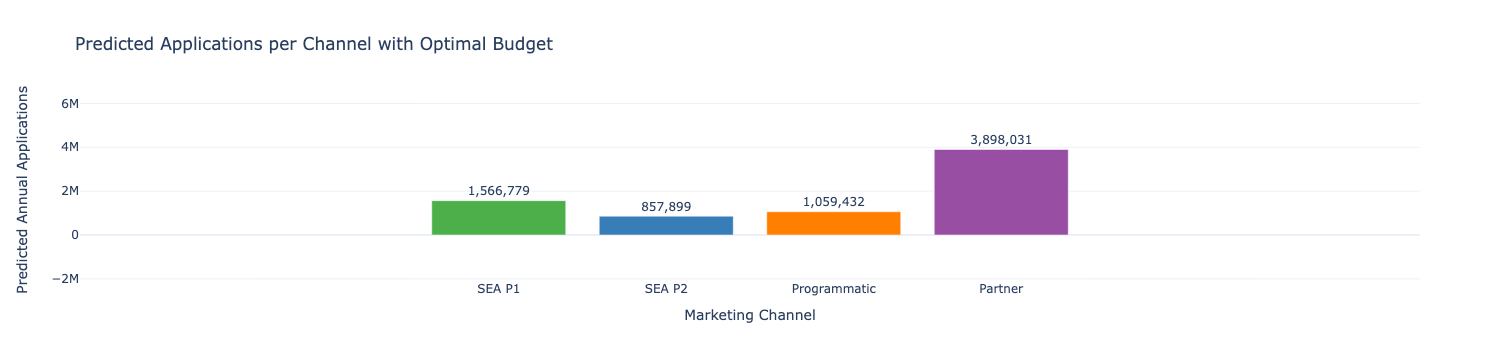

In [88]:
# Compute individual channel applications using our optimal budget
optimal_budget = {
    'SEA P1': optimal_alloc[0],
    'SEA P2': optimal_alloc[1],
    'Programmatic': optimal_alloc[2],
    'Partner': optimal_alloc[3]
}
channel_apps = compute_overall_metrics(optimal_budget, df_seap1, df_seap2, df_progd, total_listings)['Breakdown']

# Extract channel names and predicted annual applications
channels = list(channel_apps.keys())
apps_values = [channel_apps[ch] for ch in channels]

# Create a bar chart using Plotly
fig = go.Figure(data=[go.Bar(
    x=channels,
    y=apps_values,
    marker_color=['#4daf4a','#377eb8','#ff7f00','#984ea3'],
    text=[f'{int(v):,}' for v in apps_values],
    textposition='outside'
)])

# Update layout for aesthetics and readability
fig.update_layout(
    title='Predicted Applications per Channel with Optimal Budget',
    xaxis_title='Marketing Channel',
    yaxis_title='Predicted Annual Applications',
    template='plotly_white'
)

fig.show()


In [71]:
import ipywidgets as widgets
from ipywidgets import interact, fixed

In [73]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Sensitivity curve to get the local maxima which decides the allocation percentage. 

In [79]:
def create_sankey_from_allocation(budget_alloc, channels, total_budget,
                                  poly_p1, poly_p2, df_prog, total_listings):
    """
    Given a budget allocation (dict), channel names, total budget,
    and your polynomial model references (poly_p1, poly_p2, etc.),
    build a Sankey diagram plus a 'Candidates per Listing' metric in the title.
    
    budget_alloc: e.g. {'SEA P1': 1.2e6, 'SEA P2': 0.8e6, 'Programmatic': 1.5e6, 'Partner': 6.5e6}
    channels:     list of channel names, e.g. ['SEA P1','SEA P2','Programmatic','Partner']
    total_budget: total annual budget, e.g. 10_000_000
    poly_p1, poly_p2, df_prog, total_listings: references needed for your compute_overall_metrics_poly() function
    """
    # 1) Compute the results with your polynomial-based function
    results = compute_overall_metrics_poly(budget_alloc, poly_p1, poly_p2, df_prog, total_listings)
    cpl = results['Candidates per Listing']
    
    # 2) Build a Sankey diagram
    # Node 0 = "Total Budget"
    # Nodes 1..N = channels
    labels = ["Total Budget"] + channels
    
    # The 'source' for each channel is node 0
    # The 'target' is node 1..N
    sources = []
    targets = []
    values = []
    
    # For each channel i, link from 0 -> i+1
    for i, ch in enumerate(channels):
        sources.append(0)
        targets.append(i+1)
        values.append(budget_alloc[ch])
    
    fig = go.Figure(data=[go.Sankey(
        arrangement = "snap",
        node = dict(
            label = labels,
            pad = 20,
            thickness = 20
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values
        )
    )])
    
    # 3) Update layout with a title that shows 'Candidates per Listing'
    fig.update_layout(
        title_text=f"Sankey of {int(total_budget):,} € Budget — CPL: {cpl:.2f}",
        font_size=12
    )
    
    fig.show()

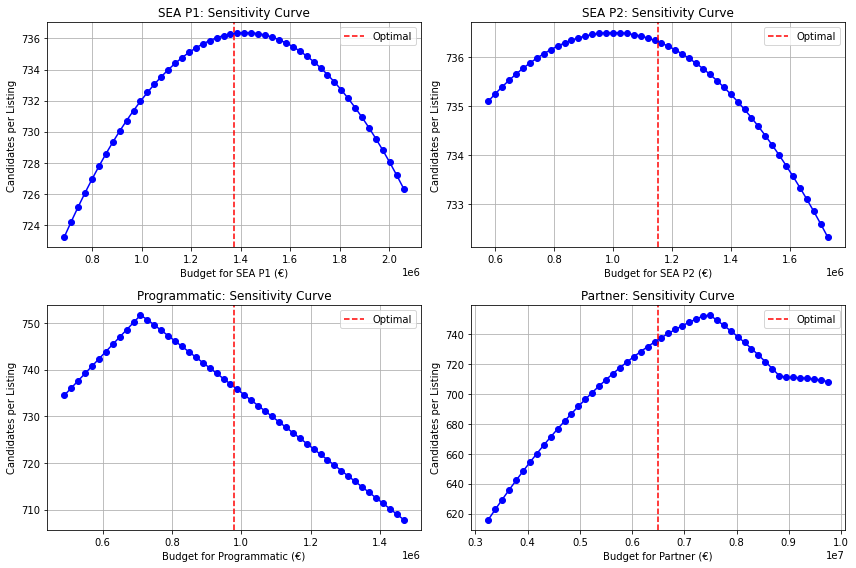

In [78]:
# Channels and optimal allocation from the quadratic optimization
channels = ['SEA P1', 'SEA P2', 'Programmatic', 'Partner']
optimal_alloc = result_quad.x  # e.g., array([optimal_S1, optimal_S2, optimal_prog, optimal_partner])
total_budget = 10_000_000  # Total annual budget

# Number of points in our sensitivity curve
n_points = 50

# Create subplots (2 rows, 2 columns), one subplot per channel
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

for i, ch in enumerate(channels):
    # For clarity, pick a range from 50% to 150% of the channel's optimal value
    x_min = optimal_alloc[i] * 0.5
    x_max = optimal_alloc[i] * 1.5
    
    # Generate the x-values (budgets) for this channel
    x_vals = np.linspace(x_min, x_max, n_points)
    
    # We'll store the resulting candidates per listing for each x in x_vals
    candidates_vals = []
    
    for x in x_vals:
        # Channel i gets budget x
        # Remaining budget is distributed among the other channels proportionally
        remaining_budget = total_budget - x
        
        # Grab the other channels' optimal budgets
        other_optimal = np.delete(optimal_alloc, i)
        sum_other_opt = other_optimal.sum()
        
        new_alloc = []
        for j in range(len(optimal_alloc)):
            if j == i:
                new_alloc.append(x)
            else:
                # Proportionally allocate the remainder
                proportion = optimal_alloc[j] / sum_other_opt
                new_alloc.append(proportion * remaining_budget)
        
        # Build the allocation dictionary
        budget_alloc = dict(zip(channels, new_alloc))
        
        # Compute the overall metrics (using the polynomial approach)
        results = compute_overall_metrics_poly(
            budget_alloc, 
            poly_p1, 
            poly_p2, 
            df_progd, 
            total_listings
        )
        
        # Append the candidates per listing to our list
        candidates_vals.append(results['Candidates per Listing'])
    
    # Now, plot the curve for this channel on subplot axs[i]
    ax = axs[i]
    ax.plot(x_vals, candidates_vals, marker='o', linestyle='-', color='blue')
    
    # Mark the optimal allocation for channel i with a red dashed line
    ax.axvline(x=optimal_alloc[i], color='red', linestyle='--', label='Optimal')
    
    ax.set_title(f"{ch}: Sensitivity Curve")
    ax.set_xlabel("Budget for " + ch + " (€)")
    ax.set_ylabel("Candidates per Listing")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

testing for the dashboard

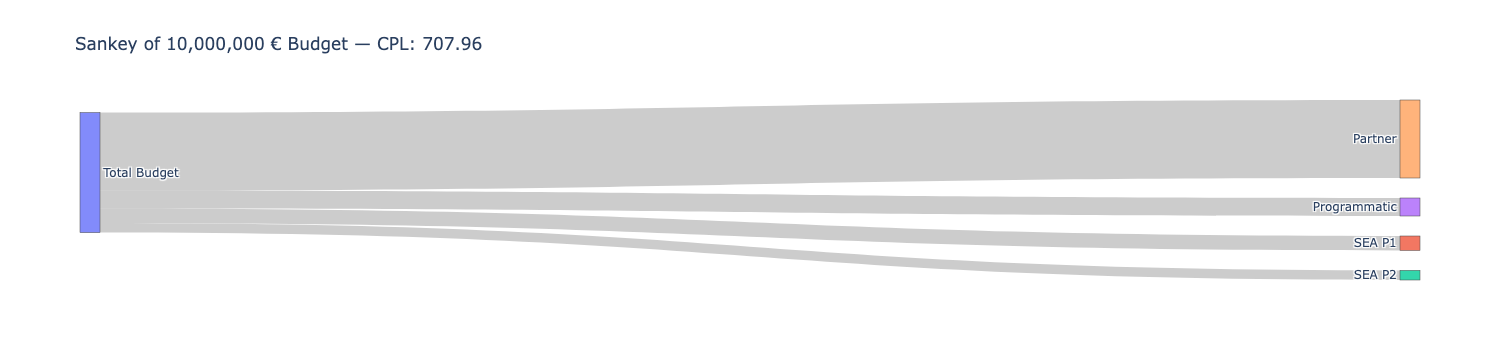

In [80]:
# Example:
channels = ['SEA P1', 'SEA P2', 'Programmatic', 'Partner']
optimal_alloc = {
    'SEA P1': 1.2e6,
    'SEA P2': 0.8e6,
    'Programmatic': 1.5e6,
    'Partner': 6.5e6
}  # or you can build it from result_quad.x
total_budget = 10_000_000

# Then call:
create_sankey_from_allocation(optimal_alloc, channels, total_budget,
                              poly_p1, poly_p2, df_progd, total_listings)

In [86]:
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go

# Assume these functions exist from your previous steps:
#  - create_sankey_from_allocation(budget_alloc, channels, total_budget, poly_p1, poly_p2, df_progd, total_listings)
#  - compute_overall_metrics_poly(...) or similar

def interactive_sankey_demo(poly_p1, poly_p2, df_prog, total_listings):
    """
    Creates an interactive widget with 4 sliders for SEA P1, SEA P2, Programmatic, and Partner.
    Each slider goes from 0 to 100, but we normalize them so their sum = 100%.
    The final distribution is used to build a Sankey diagram and compute the resulting
    candidates per listing.
    """
    total_budget = 10_000_000
    channels = ['SEA P1', 'SEA P2', 'Programmatic', 'Partner']
    
    @interact(
        sea_p1_perc=widgets.IntSlider(min=0, max=100, value=25, description='SEA P1 (%)'),
        sea_p2_perc=widgets.IntSlider(min=0, max=100, value=25, description='SEA P2 (%)'),
        prog_perc=widgets.IntSlider(min=0, max=100, value=25, description='Programmatic (%)'),
        partner_perc=widgets.IntSlider(min=0, max=100, value=25, description='Partner (%)')
    )
    def update_sliders(sea_p1_perc, sea_p2_perc, prog_perc, partner_perc):
        # 1) Gather slider values in a list/array
        raw = np.array([sea_p1_perc, sea_p2_perc, prog_perc, partner_perc], dtype=float)
        
        # 2) If sum is 0, to avoid divide by zero
        sum_raw = raw.sum()
        if sum_raw == 0:
            sum_raw = 1  # fallback
        
        # 3) Normalize so the sum = 1 (i.e., 100%)
        fractions = raw / sum_raw
        
        # 4) Build the final budget allocation in euros
        budgets = fractions * total_budget
        budget_alloc = dict(zip(channels, budgets))
        
        # 5) Create the Sankey + compute the results
        fig = _create_sankey_with_metric(budget_alloc, channels, total_budget, poly_p1, poly_p2, df_prog, total_listings)
        fig.show()
        
        # 6) Print the effective distribution in percentages
        eff_percs = fractions * 100
        for ch, p in zip(channels, eff_percs):
            print(f"{ch} -> {p:.1f}%")
    
def _create_sankey_with_metric(budget_alloc, channels, total_budget, 
                               poly_p1, poly_p2, df_prog, total_listings):
    """
    A helper function that builds a Sankey diagram from the given allocation
    and shows the resulting 'Candidates per Listing' in the title.
    """
    # 1) Compute the metrics
    results = compute_overall_metrics_poly(budget_alloc, poly_p1, poly_p2, df_prog, total_listings)
    cpl = results['Candidates per Listing']
    
    # 2) Build sankey
    labels = ["Total Budget"] + channels
    sources = []
    targets = []
    values = []
    
    for i, ch in enumerate(channels):
        sources.append(0)      # from node 0 = "Total Budget"
        targets.append(i + 1)  # node 1..4 = channels
        values.append(budget_alloc[ch])
    
    fig = go.Figure(data=[go.Sankey(
        arrangement = "snap",
        node = dict(
            label = labels,
            pad = 20,
            thickness = 20
        ),
        link = dict(
            source = sources,
            target = targets,
            value = values
        )
    )])
    
    fig.update_layout(
        title_text=f"Sankey of {int(total_budget):,} € | Candidates per Listing: {cpl:.2f}",
        font_size=12
    )
    return fig